In [23]:
import os, sys
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt


In [70]:
class PDF(object):
    #Credit: http://stackoverflow.com/questions/19470099/view-pdf-image-in-an-ipython-notebook
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('derivations_alan_eq7.pdf',size=(1000,350))

In [72]:
#
def theory_evidence():
    pass

def gibbs_samples_wcorr(n=1000,mean=(1,10),std=(0.2,0.5),corr=0.099):
    #Means: 
    m1=mean[0]; m2=mean[1]
    #Standard deviations: s1,s2
    s1=std[0]; s2=std[1]
    
    #Initialize vectors
    x=np.zeros(n)
    y=np.zeros(n)
    #correlation
    rho=corr 
    sd=np.sqrt(1-rho**2)
    # The mean for the current sample, is updated at each step.
    for i in range(1,n):
      x[i] = np.random.normal(m1+rho*(y[i-1]-m2)/s2,s1*sd)
      y[i] = np.random.normal(m2+rho*(x[i-1]-m1)/s1,s2*sd)        
        
    return x[1:], y[1:]
#
def gibbs_samples(n=1000,mean=(1,10),std=(0.2,0.5)):
    #Means: 
    m1=mean[0]; m2=mean[1]
    #Standard deviations: s1,s2
    s1=std[0]; s2=std[1]
    
    #Initialize vectors
    x=np.zeros(n)
    y=np.zeros(n)
    # The mean for the current sample, is updated at each step.
    for i in range(1,n):
      x[i] = np.random.normal(m1,s1)
      y[i] = np.random.normal(m2,s2)
        
    return x[1:], y[1:]

(10000, 2)
mean_sample, std_sample [ 0.99818115  9.98536462] [ 0.0019912   0.00497388]


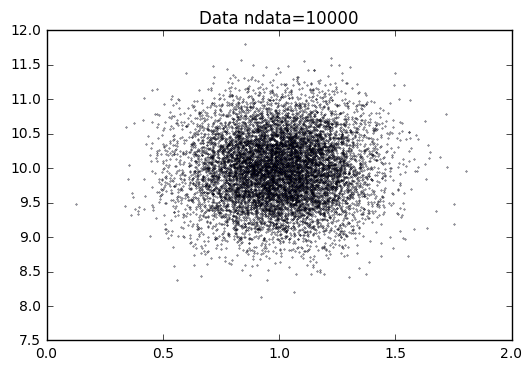

In [79]:
#  Generate data
ndata=10000
ndim=2
d2d=np.random.normal((1,10),(0.2,0.5),size=(ndata,ndim))
print(d2d.shape)
plt.scatter(d2d[:,0],d2d[:,1],s=0.1)
plt.title('Data ndata='+str(ndata))
# the sample mean and variance
mean_sample=np.mean(d2d,axis=0)
var_sample=np.var(d2d,axis=0)/ndata
std_sample=np.sqrt(var_sample)
#compute the constant term for the likelihood
tx=np.sum(d2d[:,0]**2)/var_sample[0]
ty=np.sum(d2d[:,1]**2)/var_sample[1]

print('mean_sample, std_sample',mean_sample, std_sample)

#Given data, get samples for the mean mu_x and mu_y
nchain=10000
xs,ys=gibbs_samples(n=nchain,mean=mean_sample,std=std_sample)
#compute likelihood
nlogL=0.5*ndata*(xs-mean_sample[0])**2+0.5*ndata*(ys-mean_sample[1])**2 + tx + ty

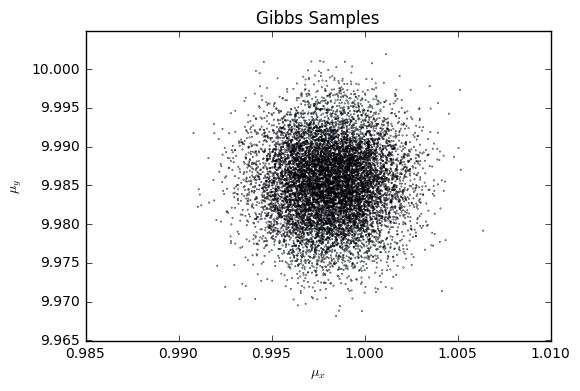

In [80]:
plt.scatter(xs,ys,s=0.1,c=nlogL/max(nlogL))
plt.title('Gibbs Samples')
plt.xlabel('$\mu_x$')
plt.ylabel('$\mu_y$')

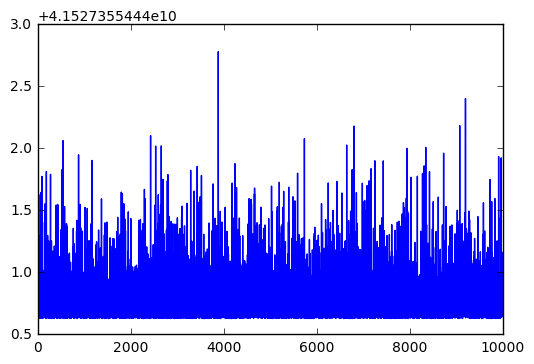

In [75]:
plt.plot(nlogL)

In [27]:
dist = DistanceMetric.get_metric('euclidean')
nnd=dist.pairwise(d2d)

In [28]:
nnd.shape

(10000, 10000)

In [20]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(d2d)
distances, indices = nbrs.kneighbors(X)

kdt = KDTree(d2d, leaf_size=30, metric='euclidean')
kdt.query(d2d, k=2, return_distance=False) 

array([[   0, 5364],
       [   1, 8678],
       [   2, 9722],
       ..., 
       [9997,  944],
       [9998, 7348],
       [9999, 5201]])